# Linear classification

**Classification tasks**

- Regression tasks: predicting real-valued quantity $y\in R$
- Classification tasks: predicting discrete-valued quantity $y$
- Binary classification: $y\in \{-1,1\}$
- Multiclass classification: $y\in \{1,2,,..., k\}$


## Linear classification example

**Example: breast cancer classification**

Well-known classification example: using machine learning to diagnose whether a 
breast tumor is benign or malignant [Street et al., 1992]

Setting: doctor extracts a sample of fluid from tumor, stains cells, then outlines 
several of the cells (image processing refines outline)

System computes features for each cell such as area, perimeter, concavity, texture 
(10 total); computes mean/std/max for all features

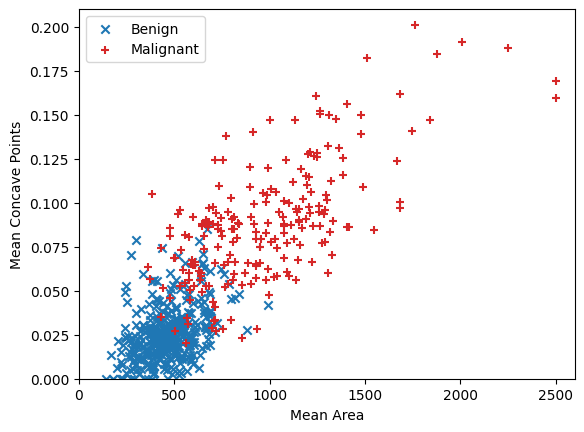

In [1]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
dat = sklearn.datasets.load_breast_cancer()

ix = np.where(dat["feature_names"] == "mean area")[0][0]
iy = np.where(dat["feature_names"] == "mean concave points")[0][0]

def plot_cells():    
    plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend(['Benign', 'Malignant'])

plot_cells()

Linear classification ≡ “drawing line separating classes”

Loss function

How do we define the loss function $l:R\times \{-1, 1\}\rightarrow R$ ?
Waht about using squered loss? That is a bad idea, actually:

![graph](../resources/m-class.png)

The loss we would like to minimize is the 0|1 loss, or just 'error':

$$l(h_{\theta}(x), y)= \begin{cases}
    0,& \text{if } sign(h_{\theta}(x))=y\\
    1,              & \text{otherwise}
\end{cases} $$

Alternative loss functions: logistic, hinge, exponential.

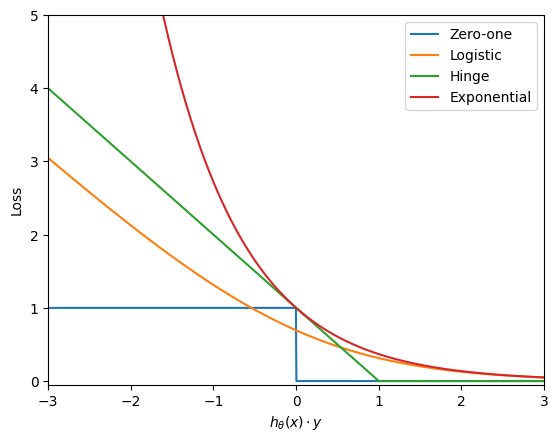

In [2]:
hy = np.linspace(-3,3,1000)
plt.plot(hy,(hy<=0))
plt.plot(hy, np.log(1+np.exp(-hy)))
plt.plot(hy, np.maximum(1 - hy, 0))
plt.plot(hy, np.exp(-hy))
plt.xlim([-3,3])
plt.ylim([-0.05, 5])
plt.ylabel("Loss")
plt.xlabel("$h_θ(x) \cdot y$")
plt.legend(['Zero-one', 'Logistic', 'Hinge', 'Exponential'])

### Machine learning optimization

With this notation, the “canonical” machine learning problem is written in the exact same 
way

$$minimize_{\theta}\sum_{i} l(h_{\theta}(x^{i}), y^{i})$$

Unlike least squares, there is not an analytical solution to the zero gradient condition for 
most classification losses.
Instead, we solve these optimization problems using gradient descent (or a alternative 
optimization method, but we’ll only consider gradient descent here)
$$Repeat: \theta:=\theta-\alpha \sum_{i}\frac{\delta}{\delta \theta} l(h_{\theta}(x^{i}), y^{i})$$

## Support Vector Machines 

Use hinge loss: $$l(h_{\theta}(x), y)= max \{1-h_{\theta}(x)\cdot y, 0\} + \lambda$$

Support vector machines also refer either to a linear hypothesis function, or a particular form of nonlinear hypothesis known as a kernel hypothesis.

$$h_{\theta}(x) = \sum_{i}\theta_{i}K(x,x^{i})$$

For now, we will consider linear kernel function.

In [3]:
def svm_gd(X, y, alpha, iters, lam):
    m,n = X.shape
    theta = np.zeros(n)
    YX = X * y[:,None]
    loss, err = np.zeros(iters), np.zeros(iters)
    for t in range(iters):
        hy = YX @ theta
        loss[t] = np.maximum(1-hy,0).mean()
        err[t] = (hy <= 0).mean()
        theta -= alpha * (-YX.T @ (YX @ theta <= 1)/m + 2*lam*theta)
    return theta, loss, err

def normalize_data(X, normalize_cols):
    """ Normalize specified columns of X to range [0,1] in place. """
    min_X = X[:,normalize_cols].min(axis=0)
    max_X = X[:,normalize_cols].max(axis=0)
    X[:,normalize_cols] = (X[:,normalize_cols] - min_X) / (max_X - min_X)
    return min_X, max_X

def unnormalize_theta(theta, normalize_cols, ranges):
    theta[normalize_cols] /= (ranges[1] - ranges[0])
    theta[-1] -= theta[normalize_cols] @ ranges[0]
    return theta

# build the data and run the SVM
X0 = np.asarray([dat["data"][:,ix], dat["data"][:,iy], np.ones(dat["data"].shape[0])]).T
y0 = (1.*(dat["target"]==np.where(dat["target_names"] == "malignant")[0][0]) +
     -1.*(dat["target"]==np.where(dat["target_names"] == "benign")[0][0]))

X, y = X0.copy(), y0.copy()
ranges = normalize_data(X, [True, True, False])
theta, loss, err = svm_gd(X,y, 1.0, 1000, 1e-3)
unnormalize_theta(theta, [True, True, False], ranges)
print(theta)



[ 1.67393642e-03  2.95613635e+01 -2.80709431e+00]


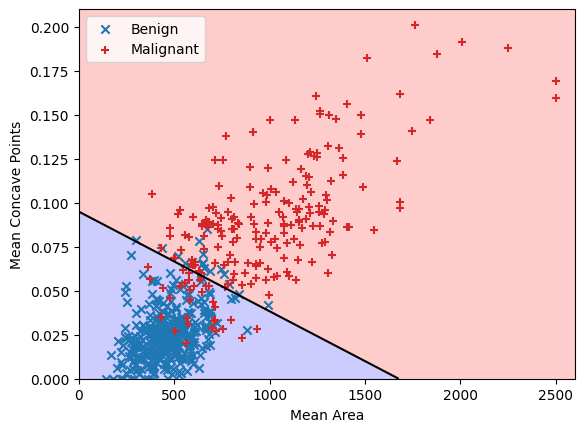

In [4]:
def plot_classification(theta):
    x_range = [0,2600]
    y_range = [0, 0.21]

    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy), np.ones(xx.size)]).T
    zz = (X_ @ theta).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-100.0,0,100.0],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    s2 = plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2], ['Benign', 'Malignant'])
    
plot_classification(theta)

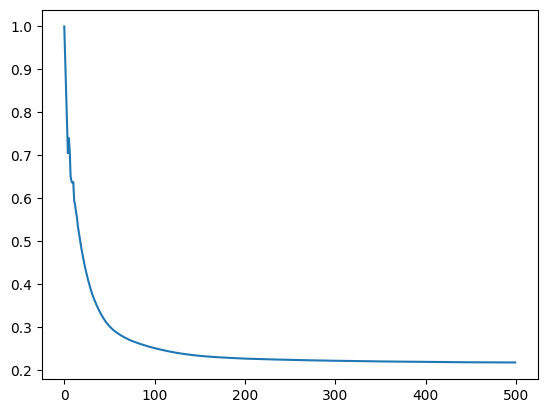

In [5]:
theta, loss, err = svm_gd(X,y, 1.0, 500, 1e-3)
plt.plot(loss)

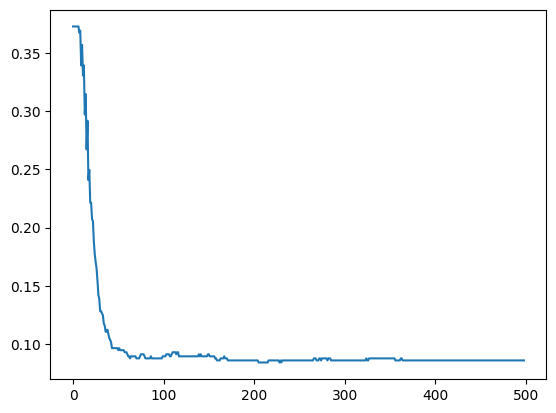

In [6]:
plt.plot(err[1:]) # err[0] is always 1.0, so we only look at 

## Logistic regression

Logistic regression results from choosing the logistic loss:

$$l_{logistic}(h_{\theta}(x), y) = log(1 + exp(-h_{\theta}(x)\cdot y))$$

Logistic regression also has a nice probabilistic interpretation: certain quantities give the probability, under a particular model, of an example being positive or negative.

In [7]:
def logistic_reg_gd(X, y, alpha, iters):
    m,n = X.shape
    theta = np.zeros(n)
    YX = X * y[:,None]
    loss, err = np.zeros(iters), np.zeros(iters)
    for t in range(iters):
        hy = YX @ theta
        loss[t] = np.log(1+np.exp(-hy)).mean()
        err[t] = (hy <= 0).mean()
        theta -= alpha * -YX.T @ (1/(1+np.exp(YX @ theta)))/m
    return theta, loss, err

In [8]:
X, y = X0.copy(), y0.copy()
mean_std = normalize_data(X, [True, True, False])
theta, loss, err = logistic_reg_gd(X,y, 1.0, 500)
unnormalize_theta(theta, [True, True, False], mean_std)
print(theta)

[ 2.78320490e-03  4.75784593e+01 -4.65379306e+00]


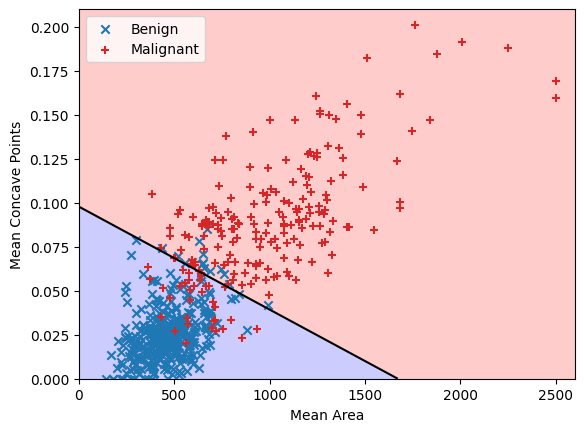

In [9]:
plot_classification(theta)

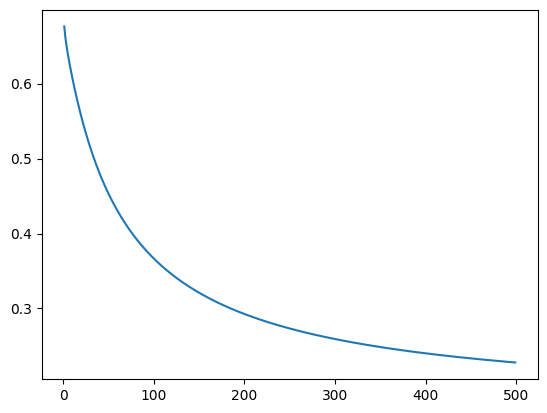

In [10]:
plt.plot(range(1,500),loss[1:])

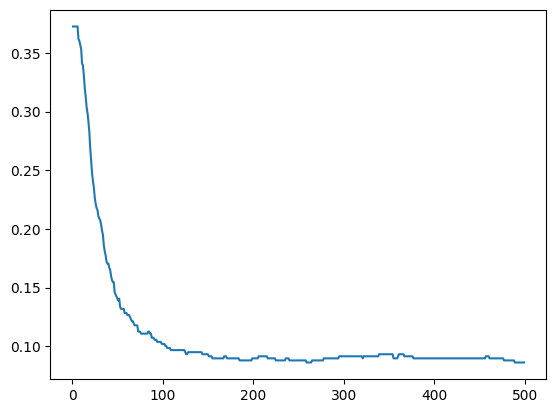

In [11]:
plt.plot(range(1,500),err[1:])

## Classification with scikit-learn

The scikit-learn library, which we previously discussed in the context of linear regression, also has built-in algorithms for classification. Using these again just requires the initialization, `.fit()`, and `.predict()` methods, with the additional note that if you want the actual output of the hypothesis function, you need to use the `.decision_function() `call.

[6.54889104e+02 4.89191459e-02] [3.51604754e+02 3.87687325e-02]
[-8.79983452e-16  9.73249991e-16] [1. 1.]


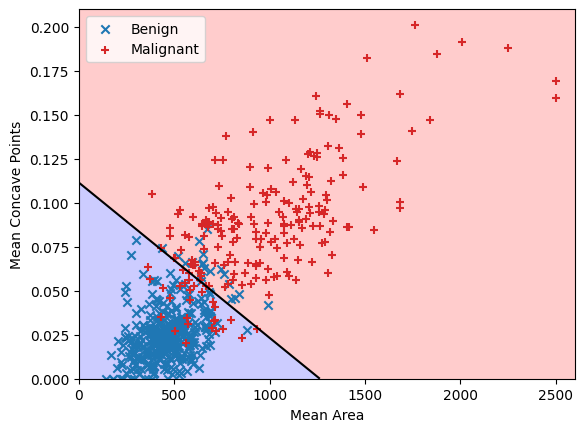

In [12]:
from sklearn.preprocessing import StandardScaler

X,y = X0.copy()[:,:-1], y0.copy() # scikit learn doesn't require additional all-ones columns
print(np.mean(X,axis=0), np.std(X,axis=0))
norm = StandardScaler()
norm.fit(X)
print(np.mean(norm.transform(X),axis=0), np.std(norm.transform(X),axis=0))

from sklearn.svm import SVC

model = SVC(kernel='linear', C = 1/(2*1e-3*X.shape[0]))
model.fit(norm.fit_transform(X), y)

(model.predict(norm.transform(X)) != y).mean()

def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]

    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    s2 = plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2], ['Benign', 'Malignant'])
    
plot_classification_sklearn(model, norm)